In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

In [2]:
def load_dataset(image_dir, label_file):
    df = pd.read_csv(label_file)
    image_paths = [os.path.join(image_dir, f"{img_id}.png") for img_id in df['id']]
    bone_ages = df['boneage'].values.astype('float32')
    genders = df['male'].astype(int).values
    return image_paths, bone_ages, genders

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256))  # Ensure consistent size
    image = tf.cast(image, tf.float32) / 255.0
    return image


def create_tf_dataset(image_paths, labels, batch_size=128):
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths) \
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((image_ds, label_ds)) \
        .batch(batch_size) \
        .prefetch(tf.data.AUTOTUNE)

In [3]:
# Load paths and labels
train_X, train_y_bone, train_y_gender = load_dataset("Train/train_samples_pp", "Train/train_labels.csv")
val_X, val_y_bone, val_y_gender = load_dataset("Val/val_samples_pp", "Val/val_labels.csv")
test_X, test_y_bone, test_y_gender = load_dataset("Test/test_samples_pp", "Test/test_labels.csv")


## CNN only on bone age

In [4]:
def cnn_bone(input_shape=(256, 256, 1)):
    input = tf.keras.Input(shape=input_shape)
    
    # Data augmentation
    x = layers.RandomRotation(factor=0.1)(input)
    x = layers.RandomTranslation(height_factor=0.05, width_factor=0.05)(x)
    x = layers.RandomFlip("horizontal")(x)
        
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='linear')(x)  # Bone age prediction
    
    model = Model(input, output)
    return model

model_bone = cnn_bone()
model_bone.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='mse',
    metrics=['mae']) # DenormalizedMAE(mean_bone, std_bone)


In [5]:
callbacks = [
    
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5, 
        restore_best_weights=True),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,  # aggressive reduction
        patience=3,
        verbose=1),
    tf.keras.callbacks.TerminateOnNaN()]

In [6]:
# Create datasets
batch_size = 128
train_bone = create_tf_dataset(train_X, train_y_bone, batch_size)
val_bone = create_tf_dataset(val_X, val_y_bone, batch_size)
test_bone = create_tf_dataset(test_X, test_y_bone, batch_size)

In [7]:
start_time = time.time()
history = model_bone.fit(
    train_bone,
    validation_data=val_bone,
    epochs=50,
    callbacks=callbacks)

end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - loss: 18093.1875 - mae: 127.0901 - val_loss: 17903.6992 - val_mae: 127.1385 - learning_rate: 1.0000e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - loss: 18085.5723 - mae: 127.0602 - val_loss: 17881.0332 - val_mae: 127.0493 - learning_rate: 1.0000e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - loss: 18056.5156 - mae: 126.9459 - val_loss: 17821.9785 - val_mae: 126.8166 - learning_rate: 1.0000e-06
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - loss: 17986.4375 - mae: 126.6699 - val_loss: 17699.4141 - val_mae: 126.3324 - learning_rate: 1.0000e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - loss: 17844.7305 - mae: 126.1094 - val_loss: 17472.9551 - val_mae: 125.4328 - learning_rate: 1.0000e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - loss: 17590.1445 - mae: 125.0977 - val_loss: 17087.9980 - val_mae: 123.8890 - learning_rate: 1.0000e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - loss:

In [8]:
# Evaluate on test set
test_loss, test_mae = model_bone.evaluate(test_bone)
print(f"Test error: {test_mae:.2f} months")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 1884.8304 - mae: 35.9464
Test MSE: 1890.71, Test MAE: 36.06 months


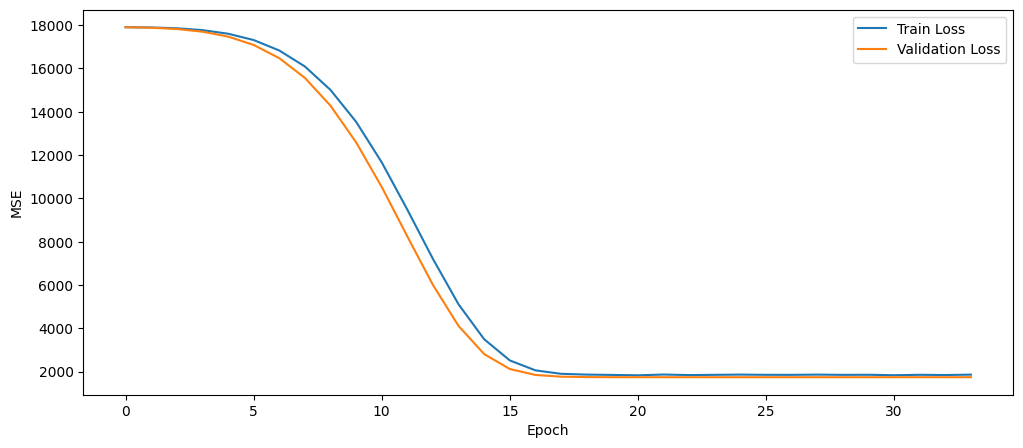

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

## CNN only on gender